In [2]:
%cd /content/drive/MyDrive/Pan_cancerData1/data2

/content/drive/MyDrive/Pan_cancerData1/data2


In [3]:
import os

In [4]:
os.listdir()

['s_4',
 's_7',
 's_9',
 's_32',
 's_6',
 's_8',
 's_5',
 's_31',
 's_33',
 's_30',
 's_25',
 's_29',
 's_22',
 's_23',
 's_3',
 's_24',
 's_26',
 's_21',
 's_27',
 's_28',
 's_13',
 's_16',
 's_20',
 's_2',
 's_17',
 's_19',
 's_12',
 's_18',
 's_15',
 's_14',
 's_10',
 's_11',
 's_1']

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

In [6]:
IMAGE_SIZE = 102 #Although our input images are 256 *256 we rescale them to 102*102 so we can use mobilenetv2
BATCH_SIZE = 16

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Pan_cancerData1/data2",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 10702 files belonging to 33 classes.


In [8]:
class_names = dataset.class_names
class_names

['s_1',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_2',
 's_20',
 's_21',
 's_22',
 's_23',
 's_24',
 's_25',
 's_26',
 's_27',
 's_28',
 's_29',
 's_3',
 's_30',
 's_31',
 's_32',
 's_33',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9']

In [9]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 102, 102, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(16, 102, 102, 3)
[ 9 26 18 31 29  6  9 31 28 16  7 22  6  6  6 25]


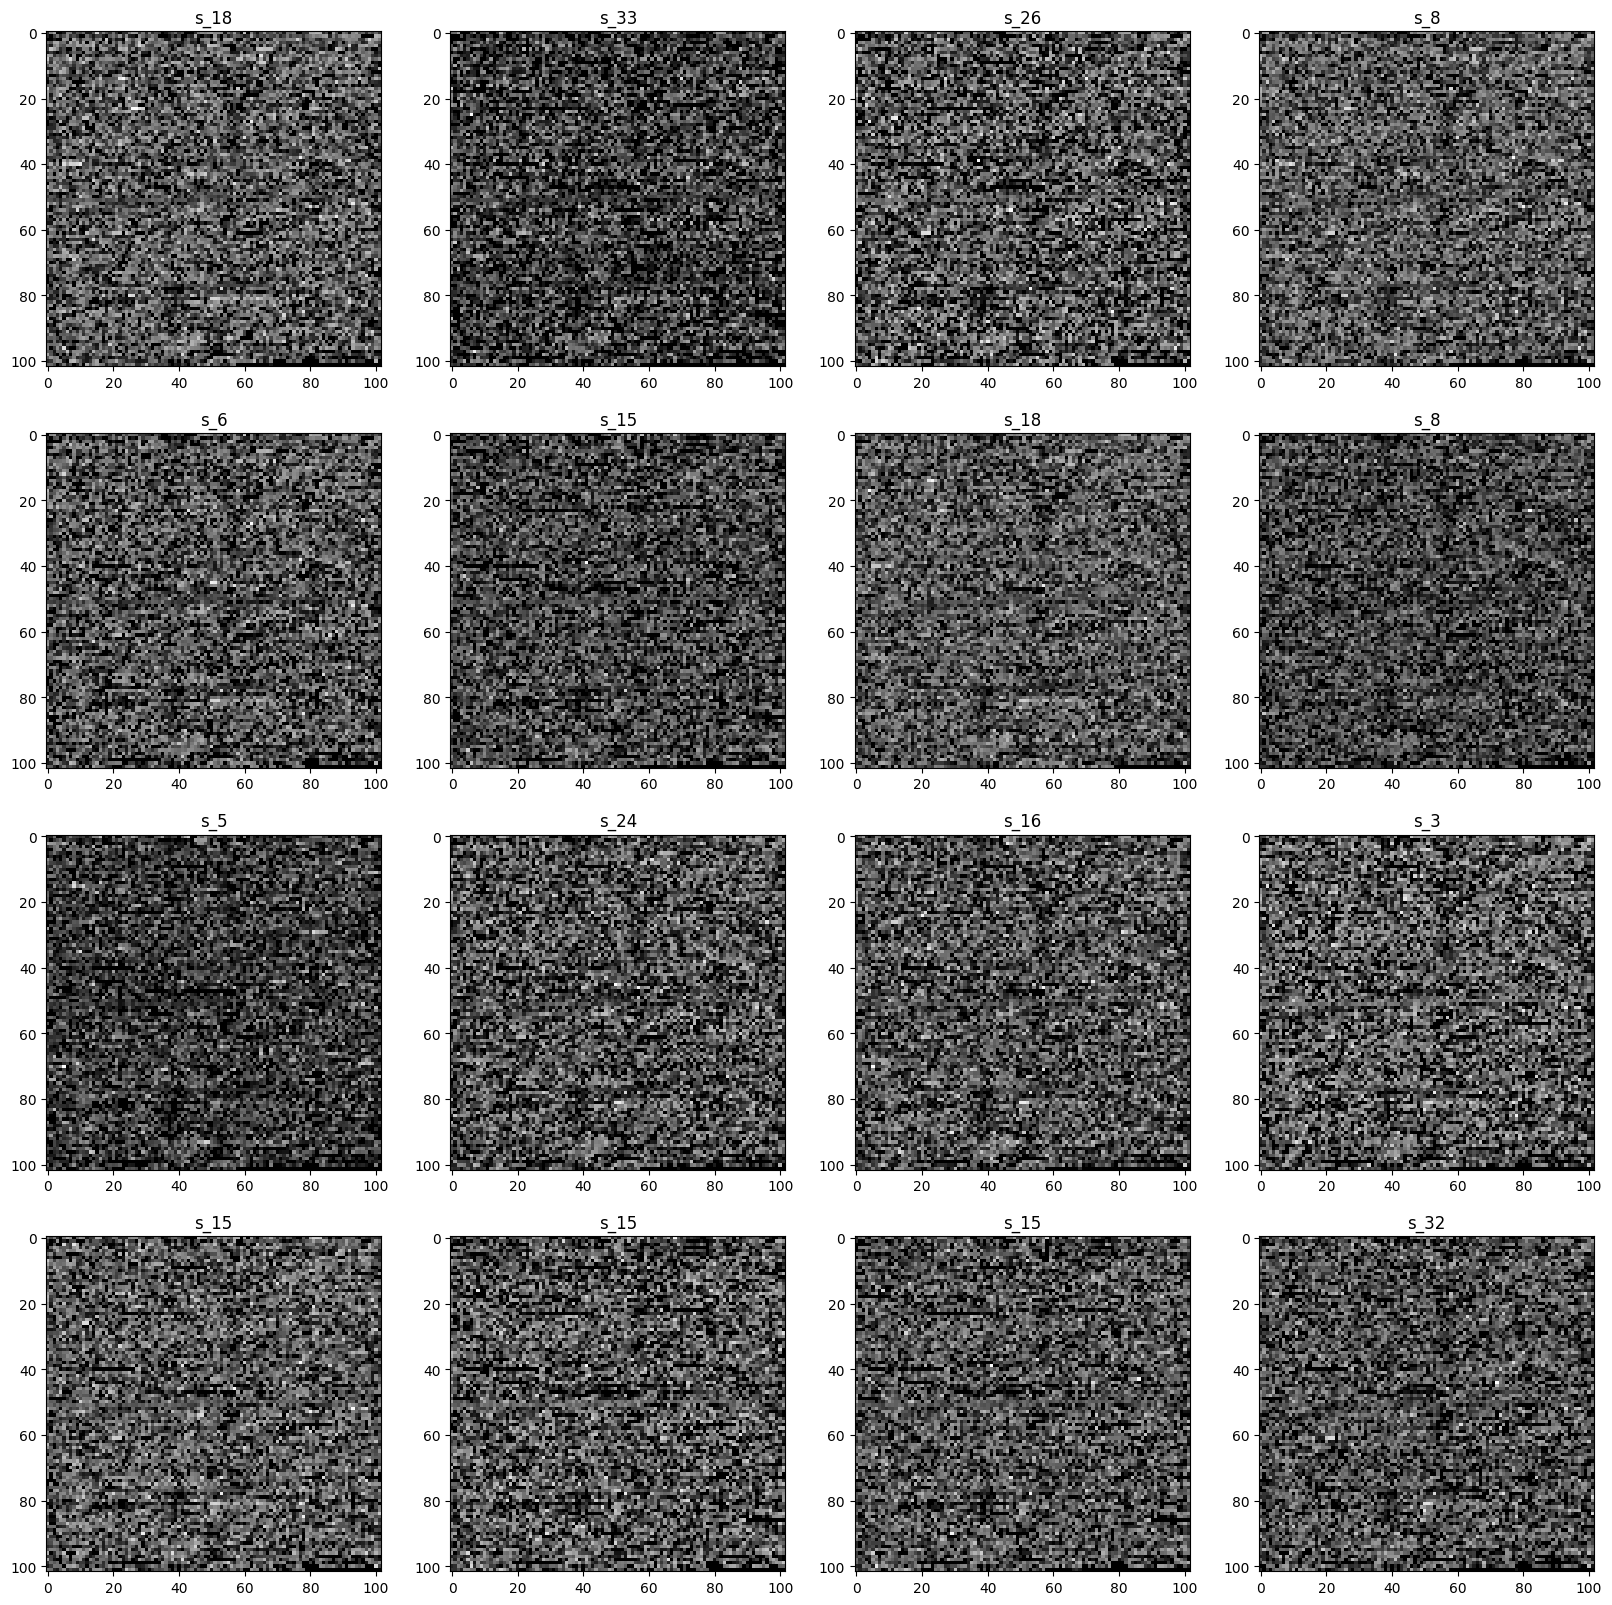

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))  # Increase plot size

# Let's explore our batch and display some images
for image_batch, label_batch in dataset.take(1):
    batch_size = image_batch.shape[0]  # Get the actual batch size
    for i in range(batch_size):
        # To visualize all images plot as subplot
        plt.subplot(4, 4, i + 1)  # Adjust the subplot layout based on the actual batch size
        # Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]])  # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))

    print(image_batch.shape)
    print(label_batch.numpy())

plt.show()  # Display the plot


In [ ]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

In [ ]:
def get_partition(ds,train_split = 0.7, validate = 0.2,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
    train_size = int(train_split*ds_size)
    val_size = int(validate*ds_size)
    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    return train,val,test

In [13]:
train,val,test = get_partition(dataset)


In [14]:
len(train)

468

In [15]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
data_augment = tf.keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
train = train.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
preprocess_input1 = tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input2 = tf.keras.applications.inception_v3.preprocess_input


In [19]:
IMG_SHAPE =  (102,102)+ (3,)

base_model1 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape= IMG_SHAPE)

base_model2 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape= IMG_SHAPE)

87910968/87910968 [==============================] - 1s 0us/step


In [20]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model1(image_batch)
print(feature_batch.shape)

image_batch, label_batch = next(iter(train))
feature_batch = base_model2(image_batch)
print(feature_batch.shape)

(16, 4, 4, 1280)
(16, 1, 1, 2048)


In [21]:
fine_tune_at = 100

for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False


In [22]:
base_model1.summary()



Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 102, 102, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 51, 51, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 51, 51, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 51, 51, 32)           0         ['bn_Conv1[

In [23]:
base_model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 102, 102, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 50, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 50, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 50, 50, 32)           0         ['batch_normalizati

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(16, 2048)


In [25]:
prediction_layer = tf.keras.layers.Dense(33, activation="softmax")

In [26]:
#First Model
inputs1 = tf.keras.Input(shape=(102, 102, 3))
x1 = preprocess_input1(inputs1)
x1 = base_model1(x1, training=False)
x1 = global_average_layer(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
outputs1 = prediction_layer(x1)
model1 = tf.keras.Model(inputs1, outputs1)
# Second model
inputs2 = tf.keras.Input(shape=(102, 102, 3))
x2 = preprocess_input2(inputs2)
x2 = base_model2(x2, training=False)
x2 = global_average_layer(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
num_classes = 33
# Create a Dense layer with the correct output size
outputs2 = tf.keras.layers.Dense(num_classes, activation='softmax')(x2)
model2 = tf.keras.Model(inputs2, outputs2)


In [72]:
base_learning_rate = 0.0001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [73]:
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 102, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 102, 102, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 102, 102, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                   

In [74]:
model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 102, 102, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 102, 102, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 102, 102, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                           

In [75]:
initial_epochs = 200


In [ ]:
history1 = model1.fit(train,epochs=initial_epochs,validation_data=val, batch_size = 16, verbose =1)

history2 = model2.fit(train,epochs=initial_epochs,validation_data=val, batch_size = 16, verbose =1)

Epoch 1/200
468/468 [==============================] - 62s 31ms/step - loss: 3.4754 - accuracy: 0.0640 - val_loss: 3.4012 - val_accuracy: 0.0959
Epoch 2/200
468/468 [==============================] - 16s 34ms/step - loss: 3.4124 - accuracy: 0.0888 - val_loss: 3.3700 - val_accuracy: 0.0959
Epoch 3/200
468/468 [==============================] - 14s 30ms/step - loss: 3.3880 - accuracy: 0.0912 - val_loss: 3.3595 - val_accuracy: 0.0959
Epoch 4/200
468/468 [==============================] - 14s 30ms/step - loss: 3.3858 - accuracy: 0.0990 - val_loss: 3.3566 - val_accuracy: 0.0959
Epoch 5/200
468/468 [==============================] - 14s 30ms/step - loss: 3.3844 - accuracy: 0.0994 - val_loss: 3.3559 - val_accuracy: 0.0959
Epoch 6/200
468/468 [==============================] - 13s 28ms/step - loss: 3.3772 - accuracy: 0.1015 - val_loss: 3.3556 - val_accuracy: 0.0959
Epoch 7/200
468/468 [==============================] - 14s 30ms/step - loss: 3.3763 - accuracy: 0.1021 - val_loss: 3.3557 - val_ac

In [ ]:
base_model1.trainable = False

base_model2.trainable = False

In [34]:
print("Number of layers in the base model1: ", len(base_model1.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

print("Number of layers in the base model2: ", len(base_model2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False




Number of layers in the base model1:  154
Number of layers in the base model2:  311


In [35]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 102, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 102, 102, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 102, 102, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                     

In [37]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 102, 102, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 102, 102, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 102, 102, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                           

In [38]:
len(model1.trainable_variables)

len(model2.trainable_variables)

2

In [39]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model1.fit(train,epochs=total_epochs, initial_epoch=history1.epoch[-1], validation_data=val,batch_size = 16,verbose =1)



Epoch 100/101
468/468 [==============================] - 18s 31ms/step - loss: 3.3669 - accuracy: 0.1027 - val_loss: 3.3558 - val_accuracy: 0.0959
Epoch 101/101
468/468 [==============================] - 13s 27ms/step - loss: 3.3635 - accuracy: 0.1027 - val_loss: 3.3557 - val_accuracy: 0.0959


In [40]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train,epochs=total_epochs, initial_epoch=history2.epoch[-1], validation_data=val,batch_size = 16,verbose = 1)

Epoch 100/101
468/468 [==============================] - 20s 33ms/step - loss: 0.3836 - accuracy: 0.8670 - val_loss: 0.6078 - val_accuracy: 0.8097
Epoch 101/101
468/468 [==============================] - 15s 31ms/step - loss: 0.3689 - accuracy: 0.8707 - val_loss: 0.5883 - val_accuracy: 0.8120


In [41]:
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']


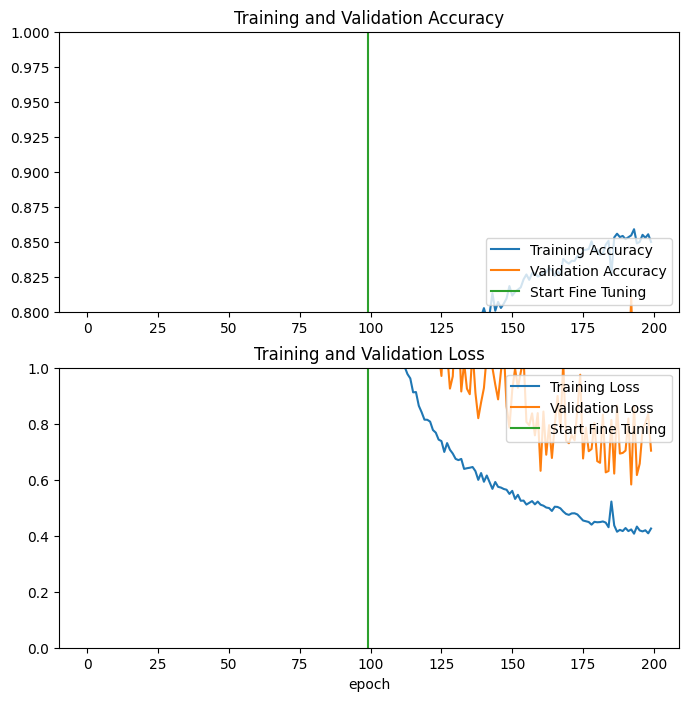

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to print
first image actual label: s_9
1/1 [==============================] - 1s 762ms/step
predicted label s_3


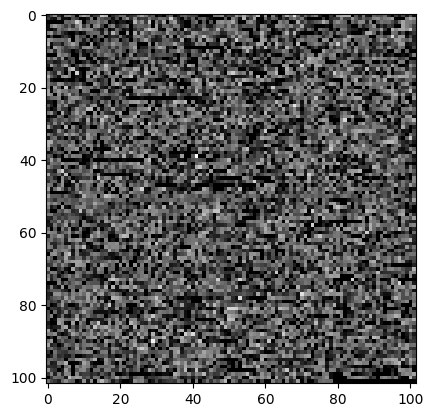

In [43]:
for image_batch,label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model1.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])


first image to print
first image actual label: s_6
1/1 [==============================] - 2s 2s/step
predicted label s_6


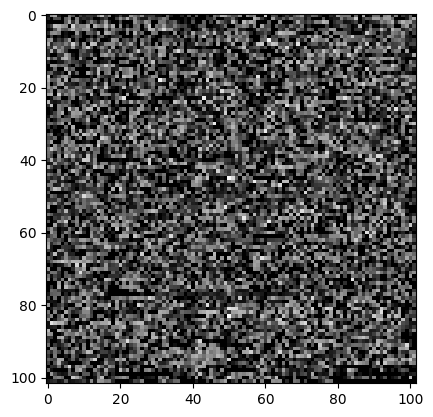

In [44]:
for image_batch,label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model2.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])




In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


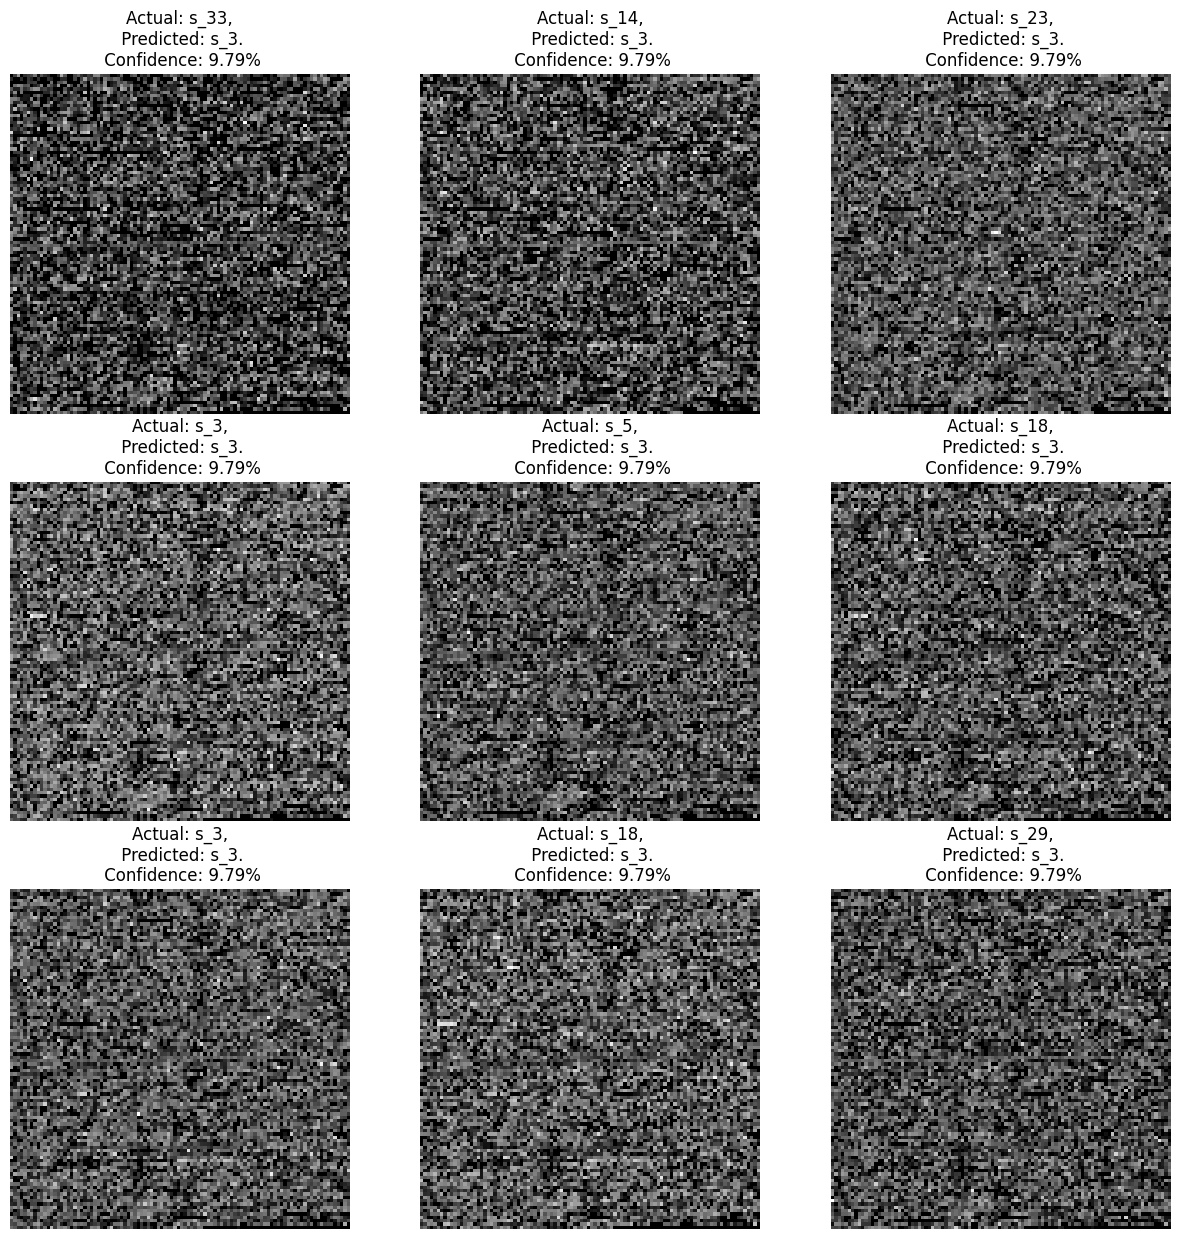

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 26ms/step


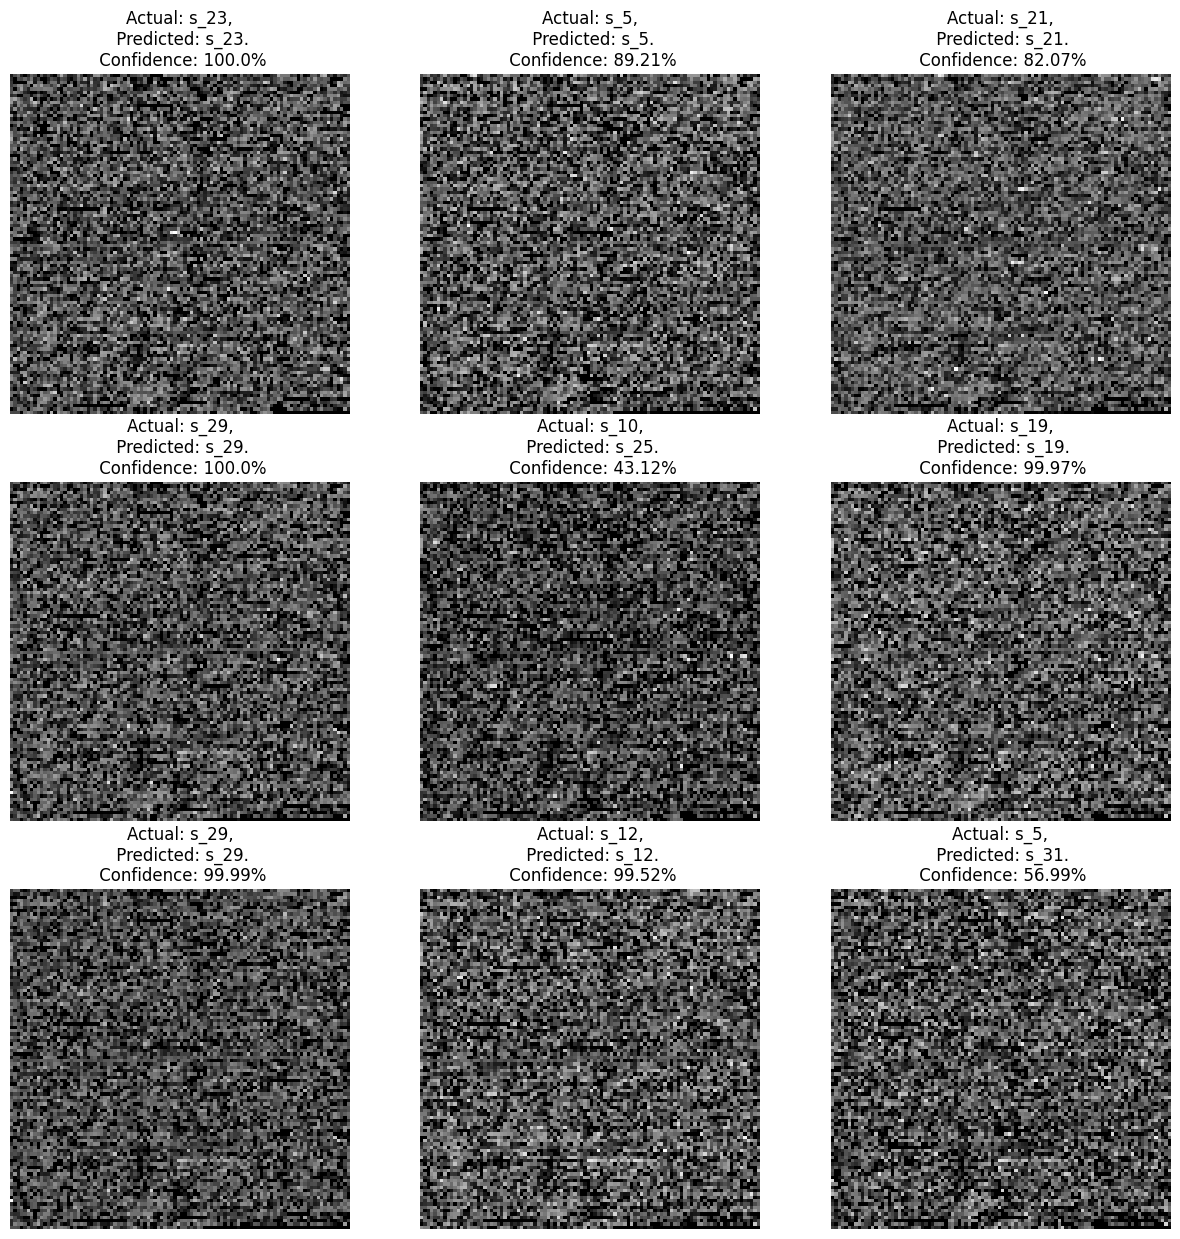

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [48]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [49]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [50]:
# Assuming models_list is defined in your code
models_list = [base_model1, base_model2, model1, model2]  # Add other models as needed

# Check the architecture of each model
for model in models_list:
    model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 102, 102, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 51, 51, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 51, 51, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 51, 51, 32)           0         ['bn_Conv1[

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Average, Dense
import os

# Assuming model_input is defined somewhere in your code
model_input = Input(shape=(102, 102, 3))

# Create individual models (base_model1, base_model2, model1, model2, etc.)
# ...

# List of individual models
models_list = [base_model1, base_model2, model1, model2]  # Add other models as needed

# Ensure the models include the final Global Average Pooling layer
outputs = [model(model_input) for model in models_list]

# Ensure all outputs have the same shape by adding a Dense layer with the correct output size to each output
num_classes = 33  # Replace with the actual number of classes in your problem

outputs = [Dense(num_classes, activation='softmax')(output) for output in outputs]

# Now, perform the averaging
ensemble_output = Average()(outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# Compile the ensemble model
base_learning_rate = 0.0001  # Adjust as needed
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                       loss='categorical_crossentropy',  # Adjust the loss function as needed
                       metrics=['accuracy'])

# Set environment variable to use all available GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = 'all'


In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ... (Your existing code up to the model creation)
num_classes = 33

# Assuming class_names contains the names of your 33 classes
class_names = ['s_1',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_2',
 's_20',
 's_21',
 's_22',
 's_23',
 's_24',
 's_25',
 's_26',
 's_27',
 's_28',
 's_29',
 's_3',
 's_30',
 's_31',
 's_32',
 's_33',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9']

# Adjust the output dimensions of the models
outputs1 = tf.keras.layers.Dense(num_classes, activation='softmax')(x1)
model1 = tf.keras.Model(inputs1, outputs1)

outputs2 = tf.keras.layers.Dense(num_classes, activation='softmax')(x2)
model2 = tf.keras.Model(inputs2, outputs2)

# Ensure the outputs have the same dimensions
common_input = tf.keras.Input(shape=(102, 102, 3))
ensemble_outputs = [model(common_input) for model in [model1, model2]]

# Create the ensemble model
ensemble_model = Model(inputs=common_input, outputs=layers.Average()(ensemble_outputs))

# Compile the ensemble model
base_learning_rate = 0.0001
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

# ... (Rest of the code for training and evaluation)

# Testing the ensemble model
test_accuracy = []
test_labels = []
predictions = []

for images, labels in test:
    ensemble_pred = ensemble_model.predict(images)
    pred_labels = np.argmax(ensemble_pred, axis=1)

    test_accuracy.extend(labels.numpy() == pred_labels)
    test_labels.extend(labels.numpy())
    predictions.extend(pred_labels)

# Calculate and print the confusion matrix
cm = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(cm)


1/1 [==============================] - 0s 46ms/step
Confusion Matrix:
[[ 0  1  0 ...  0  0  0]
 [ 0  1  4 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0 10  0]
 [ 0  0  1 ...  4  1  0]
 [ 0  0  1 ...  0  0  0]]


1/1 [==============================] - 0s 29ms/step


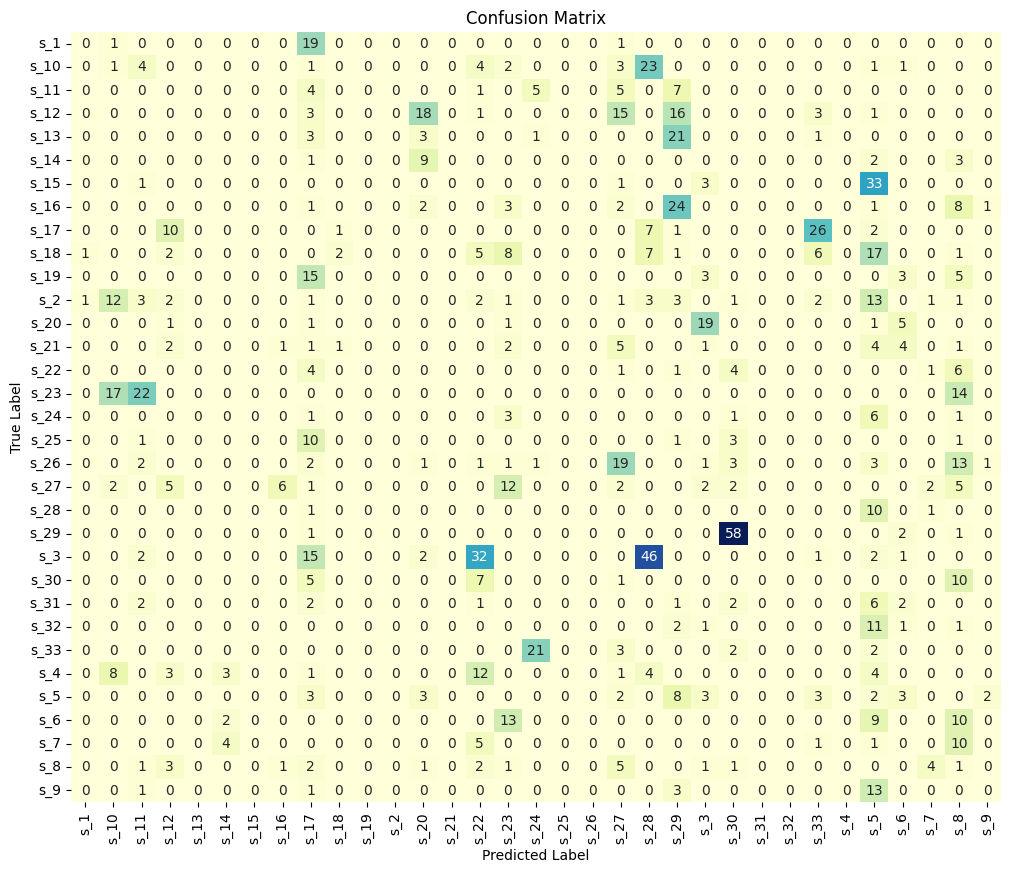

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ... (Your existing code up to the model creation)

# Assuming you have 33 classes
num_classes = 33

# Assuming class_names contains the names of your 33 classes
class_names = ['s_1', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_2', 's_20', 's_21',
               's_22', 's_23', 's_24', 's_25', 's_26', 's_27', 's_28', 's_29', 's_3', 's_30', 's_31', 's_32', 's_33', 's_4',
               's_5', 's_6', 's_7', 's_8', 's_9']

# ... (Rest of your code)

# Calculate and print the confusion matrix
test_labels = []
predictions = []

for images, labels in test:
    ensemble_pred = ensemble_model.predict(images)
    pred_labels = np.argmax(ensemble_pred, axis=1)

    test_labels.extend(labels.numpy())
    predictions.extend(pred_labels)

# Assuming test_labels and predictions are NumPy arrays
test_labels = np.array(test_labels)
predictions = np.array(predictions)

# Calculate and print the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix using seaborn with a different color palette
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ... (Rest of your code)
